In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pyiron import Project

In [3]:
data_pr = Project("../../datasets")
if len(data_pr.job_table()) == 0:
    data_pr.unpack("Cu_training_archive")

In [4]:
data_pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1,finished,None,df1_A1_A2_A3_EV_elast_phon,/df1_A1_A2_A3_EV_elast_phon,/home/pyiron/,datasets/Cu_database/,2021-02-18 19:49:53.061360,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None
1,2,finished,None,df3_10k,/df3_10k,/home/pyiron/,datasets/Cu_database/,2021-02-18 19:49:55.496691,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None
2,3,finished,None,df2_1k,/df2_1k,/home/pyiron/,datasets/Cu_database/,2021-02-18 19:49:56.101883,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None
3,4,finished,None,df4_2_5eV_25A3_8K,/df4_2_5eV_25A3_8K,/home/pyiron/,datasets/Cu_database/,2021-02-18 19:49:57.547918,None,None,zora@cmti001#1,TrainingContainer,0.4,None,None


We will use smalles dataset for fitting, as real dataset took much more time, and go outside of the scope of the workshop

In [5]:
data_job = data_pr.load('df1_A1_A2_A3_EV_elast_phon')

In [6]:
data_job.to_pandas()

,name,atoms,energy,forces,number_of_atoms
0,A1:FHI-aims/PBE/tight:elastic:s_e_0,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.699843,"[[0.0, 0.0, 0.0]]",1.0
1,A1:FHI-aims/PBE/tight:murnaghan:strain_1_0,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.699841,"[[0.0, 0.0, 0.0]]",1.0
2,A1:FHI-aims/PBE/tight:phonon:supercell_phonon_0,"(Atom('Cu', [4.3368086899420173e-19, 0.007070999999999999, 0.007070999999999999], index=0), Atom('Cu', [3.3306690738754696e-16, 1.81563, 1.8156300000000005], index=1), Atom('Cu', [7.262518, 10.893...",-236.789603,"[[-1.13852957740976e-06, -0.0464638907314277, -0.0464636807741622], [-3.86335457040412e-06, 0.0124851330231607, 0.0124792943417333], [-1.94300535086066e-06, 6.63943441884098e-05, 6.92790474109119e...",64.0
3,A1:FHI-aims/PBE/tight:murnaghan:strain_1_02,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.697932,"[[0.0, 0.0, 0.0]]",1.0
4,A1:FHI-aims/PBE/tight:murnaghan:strain_0_98,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.697559,"[[0.0, 0.0, 0.0]]",1.0
...,...,...,...,...,...
100,A2:FHI-aims/PBE/tight:elastic:s_01_e_0_05000,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.573436,"[[0.0, 0.0, 0.0]]",1.0
101,A1:FHI-aims/PBE/tight:elastic:s_01_e_m0_05000,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.546222,"[[0.0, 0.0, 0.0]]",1.0
102,A3:FHI-aims/PBE/tight:elastic:s_01_e_m0_05000,"(Atom('Cu', [1.2150849, 0.70152958, 0.9998186400000001], index=0), Atom('Cu', [0.0, 1.40305917, 2.99945593], index=1))",-7.079448,"[[-3.5446112180968e-23, -1.13427558979097e-22, 0.0], [3.5446112180968e-23, 1.13427558979097e-22, 0.0]]",2.0
103,A2:FHI-aims/PBE/tight:elastic:s_01_e_m0_05000,"(Atom('Cu', [0.0, 0.0, 0.0], index=0))",-3.513068,"[[0.0, 0.0, 0.0]]",1.0


# Fitting project

In [7]:
fit_pr = Project("pacemaker_fit")

In [8]:
job = fit_pr.create_job(job_type=fit_pr.job_type.PaceMakerJob, job_name="df1_cut5_pyace")

## Fit

In [9]:
cutoff = 5.0 # potential cutoff

Potential specification

In [10]:
job.input["cutoff"] = cutoff # global potential cutoff

In [11]:
job.input["potential"]= {
    "deltaSplineBins": 0.001, # spline bins, used for fast radial functions evaluations
    
    "element": "Cu", # element - copper    
    
    "npot": "FinnisSinclairShiftedScaled",    # embedding functions
    "ndensity": 2, # number of densities: rho_1 and rho_2
    "fs_parameters": [1, 1, 1, 0.5], # parameters of embedding functions (for two densities)
    #this embedding function corresponds to rho_1 + sqrt(abs(rho_2)) , with some modifications
    
    # radial base functions specification
    "radbase": "ChebExpCos",
    "radparameters": [5.25],
    "rcut": cutoff,
    "dcut": 0.01,
    "NameOfCutoffFunction": "cos",
    
    # MOST IMPORTANT: potential "shape" i.e.:
    # number of orders (rank), maximum index of radial functions (nradmax) and orbital moments (lmax) for each rank
    "rankmax": 3,
    "nradmax": [7,2,1],
    "lmax": [0,2,1],    
}

Fitting settings:

In [12]:
job.input["fit"]= {    
    # loss function specification
    'loss': {
        'kappa': 0.5, # relative weight of forces residuals
        
        # coefficients L1-L2 regularization
        'L1_coeffs': 5e-7, # L1-regularization
        'L2_coeffs': 5e-7, # L2-regularization
        'w1_coeffs': 1,
        'w2_coeffs': 1,
        
        #radial smoothness regularization
        'w0_rad': 1e-4,     # for radial functions values
        'w1_rad': 1e-4,     # for radial functions first derivatives
        'w2_rad': 1e-4,     # for radial functions second derivatives
    },
    
    # minimization setup:
    'optimizer': 'BFGS',  # scipy BFGS algorithm
    'maxiter': 150,       # max number of iterations    
}

Assign the dataset to fit on

In [13]:
job.structure_data=data_job

Run fitting job

In [14]:
job.run()

2021-03-09 09:13:42,018 - root - INFO - structure_data is TrainingContainer
2021-03-09 09:13:42,021 - root - INFO - Saving training structures dataframe into /home/pyiron/day_2/03-ace/pacemaker_fit/df1_cut5_pyace_hdf5/df1_cut5_pyace/df_fit.pckl.gzip with pickle protocol = 4, compression = gzip


The job df1_cut5_pyace was saved and received the ID: 76


In [15]:
fit_pr.job_table(full_table=True)

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,76,finished,None,df1_cut5_pyace,/df1_cut5_pyace,/home/pyiron/,day_2/03-ace/pacemaker_fit/,2021-03-09 09:13:42.059294,2021-03-09 09:18:39.142853,297.0,pyiron@jupyter-janssen#1,PaceMakerJob,0.1,None,None


# Analyse the fitting results

loss function

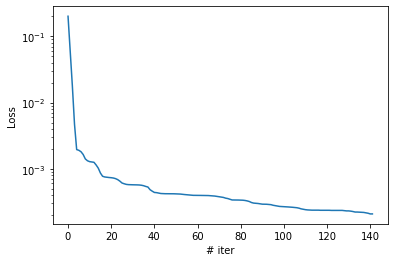

In [16]:
plt.plot(job["output/log/loss"])
plt.yscale('log')
plt.xlabel("# iter")
plt.ylabel("Loss");

RMSE of energies per atoms 

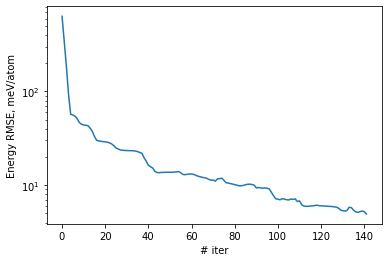

In [17]:
plt.plot(job["output/log/rmse_energy"])
plt.yscale('log')
plt.xlabel("# iter")
plt.ylabel("Energy RMSE, meV/atom");

RMSE of forces norm

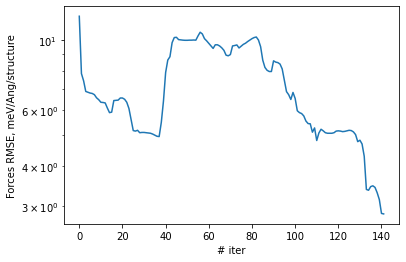

In [18]:
plt.plot(job["output/log/rmse_forces"])
plt.yscale('log')
plt.xlabel("# iter")
plt.ylabel("Forces RMSE, meV/Ang/structure");

# Overview of the fitted potential internals

In [19]:
from pyace import *

In [20]:
final_potential = job.get_final_potential()
final_basis_set = ACEBBasisSet(final_potential)

For single-species potential there is only one **species block** for *Cu*:

In [21]:
len(final_potential.funcspecs_blocks)

1

In [22]:
Cu_block = final_potential.funcspecs_blocks[0]

Basic definitions and notations:

* Radial functions: $R_{nl}(r) = \sum_k c_{nlk} g_k(r)$


* Spherical harmonics:  $  Y_{lm}(\hat{\pmb{r}}_{ji}) $


* Basis function: $\phi_{\mu_j \mu_i nlm}(\pmb{r}_{ji}) = R_{nl}^{\mu_j \mu_i}(r_{ji}) Y_{lm}(\hat{\pmb{r}}_{ji}) $


* Atomic base (A-functions): $ A_{i \mu n l m} = \sum_j \delta_{\mu \mu_j} \phi_{\mu_j\mu_i nlm}(\pmb{r}_{ji})  $


* Product of atomic base: $ \pmb{A}_{i\pmb{\mu n l m}} =  \prod_{t = 1}^{\nu} A_{i \mu_t n_t l_t m_t}  $


* Equivariant basis (B-functions):  $  {B}_{i\pmb{\mu n l L}}  = \sum_{\pmb{m}}   \left(
\begin{array}{c} 
\pmb{l m} \\
\pmb{L M}
\end{array}
L_R
\right)  \pmb{A}_{i\pmb{\mu n l m}}  $ ,

where $ \left(\begin{array}{c} \pmb{l m} \\ \pmb{L M}\end{array} L_R\right) $ is *generalized Clebsh-Gordan coefficients* 


* Atomic property (densities) $ \rho_i^{(p)} = \sum_{\pmb{\mu n l L}} {c}^{(p)}_{\mu_i\pmb{\mu n l L}} {B}_{i\pmb{\mu n l L}}  $


* Atomic energy: $ E_i = F(\rho_i^{(1)}, \dots,\rho_i^{(P)} )  $, where $F$ is embedding function

radial coefficients $c_{nlk}$:

In [23]:
np.shape(Cu_block.radcoefficients)

(2, 3, 7)

Visualize the radial basis functions ($g_k$) and radial functions ($R_{nl}$) and their derivatives:

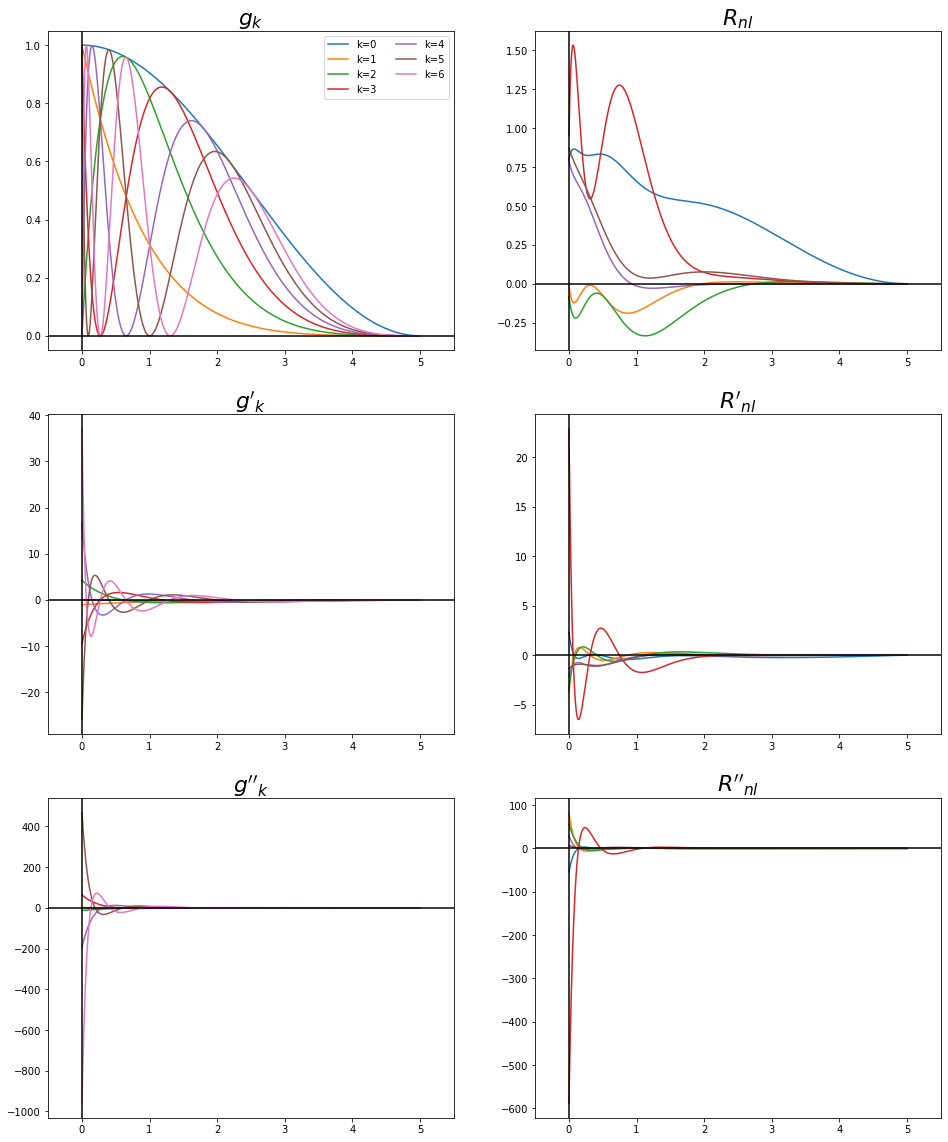

In [24]:
RadialFunctionsVisualization(final_basis_set).plot()

Total number of basis functions

In [25]:
len(Cu_block.funcspecs)

18

List of B-basis functions $ {B}_{i\pmb{\mu n l L}}$: $\pmb{\mu} = $ `elements`, $\pmb{n} = $ `ns`, $\pmb{l} = $ `ls`, $\pmb{L} = $ `LS`)  and corresponding coefficients $ {c}^{(p)}_{\mu_i\pmb{\mu n l L}} =$ `coeffs` for two densities

In [26]:
Cu_block.funcspecs

[BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[1],  ls=[0],  coeffs=[-0.95121,-0.202222]),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[2],  ls=[0],  coeffs=[0.14178,0.0409501]),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[3],  ls=[0],  coeffs=[0.436094,0.14006]),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[4],  ls=[0],  coeffs=[0.526956,0.183426]),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[5],  ls=[0],  coeffs=[0.173617,0.0969896]),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[6],  ls=[0],  coeffs=[-0.450901,-0.0592275]),
 BBasisFunctionSpecification(elements=[Cu,Cu],  ns=[7],  ls=[0],  coeffs=[-0.712825,-0.117959]),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[1,1],  ls=[0,0],  coeffs=[0.160119,0.116377]),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[1,1],  ls=[1,1],  coeffs=[0.0465253,0.0096226]),
 BBasisFunctionSpecification(elements=[Cu,Cu,Cu],  ns=[1,1],  ls=[2,2],  coeffs=[0.399933,0.110766]),
 BBasisFunctionSpecif

Compare to potential "shape" i.e.:
* "rankmax": 3
* "nradmax": [7,2,1]
* "lmax": [0,2,1]

In [27]:
print("Trainable parameters number")
print()
print("B-functions coefficients: ",Cu_block.ndensityi * len(Cu_block.funcspecs))
print("Radial functions coefficients: ",len(np.array(Cu_block.radcoefficients).flatten()))
print("-"*40)
print("Total number of trainable parameters: ",len(final_potential.get_all_coeffs()))

Trainable parameters number

B-functions coefficients:  36
Radial functions coefficients:  42
----------------------------------------
Total number of trainable parameters:  78


# Test fitted potential

In [28]:
test_pr = Project("test_ace_potential")

In [29]:
test_pr.remove_jobs_silently()

In [30]:
test_pr.job_table()

""


In [31]:
cu_ace_potential = job.get_lammps_potential()

In [32]:
cu_ace_potential


,Config,Filename,Model,Name,Species
0,"[pair_style pace\n, pair_coeff * * /home/pyiron/day_2/03-ace/pacemaker_fit/df1_cut5_pyace_hdf5/df1_cut5_pyace/df1_cut5_pyace.ace Cu\n]",,ACE,df1_cut5_pyace,[Cu]


## Optimization

In [33]:
lammps_job = test_pr.create.job.Lammps("opt_lammps", delete_existing_job=True)

In [34]:
lammps_job.potential = cu_ace_potential

In [35]:
lammps_job.structure = test_pr.create.structure.ase_bulk("Cu","fcc",cubic=True)

<ipython-input-35-d2e1f8892ec0>:1: DeprecationWarning: pyiron_atomistics.atomistics.structure.factory.ase_bulk is deprecated: Please use .bulk or .ase.bulk. It is not guaranteed to be in service in vers. 0.2.2
  lammps_job.structure = test_pr.create.structure.ase_bulk("Cu","fcc",cubic=True)


In [36]:
lammps_job.calc_minimize(pressure=0.0)

In [37]:
lammps_job.run()

The job opt_lammps was saved and received the ID: 77


In [38]:
test_pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,77,finished,Cu4,opt_lammps,/opt_lammps,/home/pyiron/,day_2/03-ace/test_ace_potential/,2021-03-09 09:18:42.055287,2021-03-09 09:18:42.413620,0.0,pyiron@jupyter-janssen#1,Lammps,0.1,None,None


## E-V curve

In [39]:
ev_job = test_pr.create.job.Murnaghan("murn", delete_existing_job=True)

In [40]:
ref_job = test_pr.create.job.Lammps("ref_job", delete_existing_job=True)

In [41]:
ref_job.potential = cu_ace_potential

In [42]:
ref_job.structure = lammps_job.get_structure()

In [43]:
ev_job.ref_job = ref_job

In [44]:
ev_job.run()

The job murn was saved and received the ID: 78
The job strain_0_9 was saved and received the ID: 79
The job strain_0_92 was saved and received the ID: 80
The job strain_0_94 was saved and received the ID: 81
The job strain_0_96 was saved and received the ID: 82
The job strain_0_98 was saved and received the ID: 83
The job strain_1_0 was saved and received the ID: 84
The job strain_1_02 was saved and received the ID: 85
The job strain_1_04 was saved and received the ID: 86
The job strain_1_06 was saved and received the ID: 87
The job strain_1_08 was saved and received the ID: 88
The job strain_1_1 was saved and received the ID: 89
job_id:  79 finished
job_id:  80 finished
job_id:  81 finished
job_id:  82 finished
job_id:  83 finished
job_id:  84 finished
job_id:  85 finished
job_id:  86 finished
job_id:  87 finished
job_id:  88 finished
job_id:  89 finished


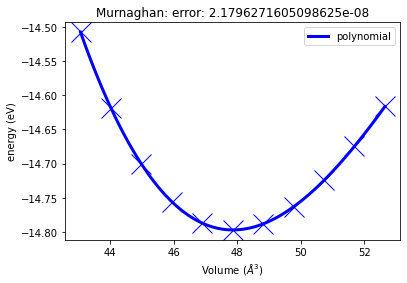

In [45]:
ev_job.plot()

In [46]:
ev_job["output/equilibrium_bulk_modulus"]

157.26478378968022

In [47]:
ev_job["output/equilibrium_b_prime"]

5.871581007824487

In [48]:
ev_job["output/equilibrium_energy"]/4

-3.6992805045165476

In [49]:
ev_job["output/equilibrium_volume"]/4

11.966449592242205

# Advanced (already trained) potential

More advanced Cu potential trained on `df3` and longer range (`cutoff=7.5`)

In [50]:
advanced_potential = BBasisConfiguration("good_potentials/df3_cut75_large_body_order.yaml")

In [51]:
advanced_basis_set = ACEBBasisSet(advanced_potential)

For single-species potential there is only one **species block** for *Cu*:

In [52]:
len(advanced_potential.funcspecs_blocks)

1

In [53]:
Cu_block = advanced_potential.funcspecs_blocks[0]

radial coefficients $c_{nlk}$:

In [54]:
np.shape(Cu_block.radcoefficients)

(4, 5, 15)

In [55]:
print("Cutoff: ",Cu_block.rcutij, " Ang")

Cutoff:  7.5  Ang


Visualize the radial basis functions ($g_k$) and radial functions ($R_{nl}$) and their derivatives:

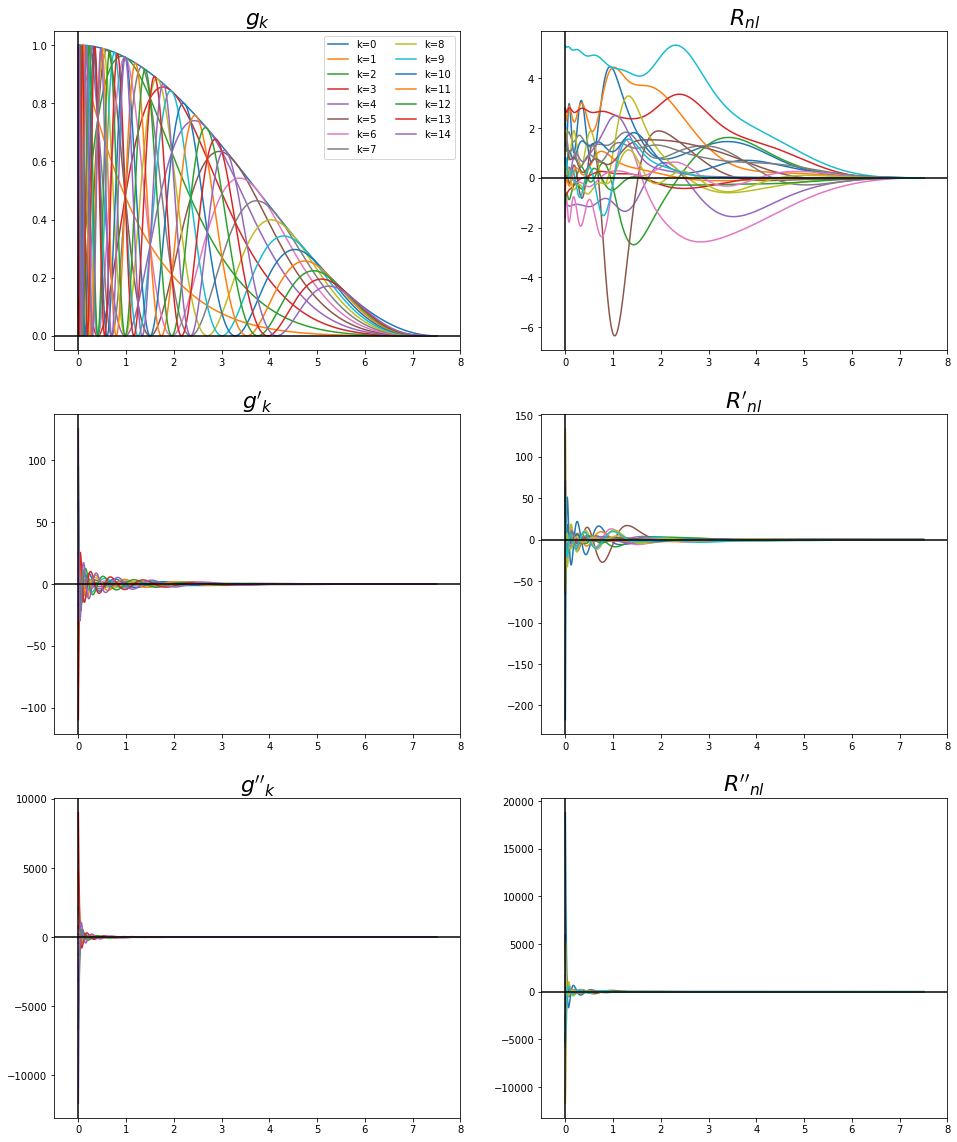

In [56]:
RadialFunctionsVisualization(advanced_basis_set).plot()

Total number of basis functions

In [57]:
len(Cu_block.funcspecs)

208

List of B-basis functions $ {B}_{i\pmb{\mu n l L}}$: $\pmb{\mu} = $ `elements`, $\pmb{n} = $ `ns`, $\pmb{l} = $ `ls`, $\pmb{L} = $ `LS`)  and corresponding coefficients $ {c}^{(p)}_{\mu_i\pmb{\mu n l L}} =$ `coeffs` for two densities

first 20 B-functions

In [58]:
Cu_block.funcspecs[:20]

[BBasisFunctionSpecification(elements=[Al,Al],  ns=[1],  ls=[0],  coeffs=[0.778052,-0.641316]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[2],  ls=[0],  coeffs=[2.23777,0.156201]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[3],  ls=[0],  coeffs=[4.43693,-0.13343]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[4],  ls=[0],  coeffs=[1.47578,-1.28301]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[5],  ls=[0],  coeffs=[-2.59834,-1.53179]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[6],  ls=[0],  coeffs=[-1.69264,0.330513]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[7],  ls=[0],  coeffs=[1.43426,2.03646]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[8],  ls=[0],  coeffs=[0.770394,0.734637]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[9],  ls=[0],  coeffs=[-1.5626,-1.94086]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[10],  ls=[0],  coeffs=[-0.302523,-1.69641]),
 BBasisFunctionSpecification(elements=[Al,Al],  ns=[1

last 20 B-functions

In [59]:
Cu_block.funcspecs[-20:]

[BBasisFunctionSpecification(elements=[Al,Al,Al,Al],  ns=[3,3,2],  ls=[2,1,1],  LS=[1],  coeffs=[-0.0108445,0.0344024]),
 BBasisFunctionSpecification(elements=[Al,Al,Al,Al],  ns=[3,3,2],  ls=[2,2,0],  LS=[0],  coeffs=[0.00323158,0.229271]),
 BBasisFunctionSpecification(elements=[Al,Al,Al,Al],  ns=[3,3,2],  ls=[2,2,2],  LS=[2],  coeffs=[-0.000115442,0.0766528]),
 BBasisFunctionSpecification(elements=[Al,Al,Al,Al],  ns=[3,3,2],  ls=[3,2,1],  LS=[1],  coeffs=[0.00202504,-0.0988705]),
 BBasisFunctionSpecification(elements=[Al,Al,Al,Al],  ns=[3,3,2],  ls=[3,3,0],  LS=[0],  coeffs=[-0.00468792,0.125821]),
 BBasisFunctionSpecification(elements=[Al,Al,Al,Al],  ns=[3,3,2],  ls=[3,3,2],  LS=[2],  coeffs=[0.00633233,-0.0604226]),
 BBasisFunctionSpecification(elements=[Al,Al,Al,Al],  ns=[3,3,3],  ls=[0,0,0],  LS=[0],  coeffs=[-0.00257037,0.0733903]),
 BBasisFunctionSpecification(elements=[Al,Al,Al,Al],  ns=[3,3,3],  ls=[1,1,0],  LS=[0],  coeffs=[0.0269804,0.496832]),
 BBasisFunctionSpecification(e

In [60]:
print("Trainable parameters number")
print()
print("B-functions coefficients: ",Cu_block.ndensityi * len(Cu_block.funcspecs))
print("Radial functions coefficients: ",len(np.array(Cu_block.radcoefficients).flatten()))
print("-"*40)
print("Total number of trainable parameters: ",len(advanced_potential.get_all_coeffs()))

Trainable parameters number

B-functions coefficients:  416
Radial functions coefficients:  300
----------------------------------------
Total number of trainable parameters:  716
